# Latent Dirichlet Allocation - Youtube

In [1]:
#Gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import pt_core_news_sm
#NLTK
import nltk;nltk.download('stopwords')
from nltk.corpus import stopwords
#Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
#Plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rache\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Criando Lista de Documentos

Nesta análise, criamos uma lista com 8 strings (textos) contendo todos os comentários de um canal. Cada posição dessa lista corresponde a um médico e é interpretada como um documento pelo modelo LDA.

In [2]:
#Lendo arquivo csv
df = pd.read_csv("comentarios1.csv", encoding='utf-8')

#Excluindo colunas desnecessárias
df = df[['uploader', 'text']]

#Agrupando dataframe por uploaders e criando uma lista (lista_canais) com os grupos
df_grouped = df.groupby('uploader')
lista_canais = []
for canal in df_grouped.groups:
    lista_canais.append(df_grouped.get_group(canal))
lista_documentos = []

#Criando lista de documentos
documento = ''
for canal in lista_canais:
    for comentario in canal['text']:
        documento = documento + ' ' + comentario
    lista_documentos.append(documento)
    documento = ''
lista_documentos = [gensim.utils.deaccent(documento) for documento in lista_documentos] #removendo acentos das palavras

## Pré-processamento

Na etapa de pré-processamento, eliminamos tudo que não é considerado interessante para fazer a análise. Dentre isso estão, urls, emails, caracteres especiais e emojis. Além disso, é feita a remoção das chamadas stop words, que são palavras ou muito comuns ou que não fornecem muitas informações, para a análise que queremos fazer, como pronomes e preposições. Nesse caso escolhemos deixar apenas adjetivos, substantivos (excluindo nomes próprios), e verbos (exceto ser, estar, ter e fazer). Por fim, tokenizamos os documentos, o que equivale a quebrar um texto em uma lista de palavras. 

In [3]:
##########REMOVENDO TUDO QUE NÃO SÃO PALAVRAS###############
#Removendo urls
lista_documentos = [re.sub(r'http\S+', '', str(documento)) for documento in lista_documentos]
#Removendo emails
lista_documentos = [re.sub(r'\S*@\S*\s?', '', documento) for documento in lista_documentos]
#Removendo caracteres de new line
lista_documentos = [re.sub(r'\s+', ' ', documento) for documento in lista_documentos]
#Removendo caracteres especiais
lista_documentos = [re.sub(r'([^a-zA-Z\s]+?)', '', documento) for documento in lista_documentos]

##########REMOVENDO PALAVRAS################################
#Obtendo lista de stop words em português da biblioteca nltk
stop_words = stopwords.words('portuguese')
#Palavras em inglês e espanhol
stop_words.extend(['you', 'good', 'the', 'to', 'live', 'very', 'your', 'work', 'is', 'my', 'from', 'love', 'and', 'in', 'thank', 'informative', 'are', 'of', 'un', 'english', 'what', 'mi', 'hello', 'el', 'but', 'doctor'])
#Nomes Próprios e pronomes de tratamento
stop_words.extend(['drauzio', 'lucy', 'fernando', 'pinto', 'gomes', 'lair', 'ribeiro', 'alvaro', 'galvao', 'gomez', 'kerr', 'dra', 'sr', 'senhora', 'dr', 'senhor'])
#Pronomes
stop_words.extend(['pra', 'vc', 'todos', 'tudo', 'cada', 'nada', 'sobre', 'outros', 'voce'])
#Conjunções
stop_words.extend(['porque', 'pois', 'pq'])
#Advérbios
stop_words.extend(['assim', 'bem', 'ainda', 'agora', 'sim', 'sempre', 'aqui', 'la', 'tbm', 'ai', 'hoje', 'quase', 'logo', 'nao', 'ja', 'so', 'tambem'])
#Verbos frequentes
stop_words.extend(['vai', 'ser', 'ter', 'ta', 'fazer', 'fiz', 'faz', 'vou', 'sao', 'estao'])
#Outros
stop_words.extend(['boa', 'bom', 'obrigado', 'ola'])
#Preposições
stop_words.extend(['ate'])

#Etapa de Tokenização
lista_documentos = [gensim.utils.simple_preprocess(str(documento), deacc=True) for documento in lista_documentos]
#Removendo stop words
lista_documentos = [[word for word in documento if word not in stop_words] for documento in lista_documentos]

Aqui filtramos todas as palavras com frequência menor ou igual a 3.

In [4]:
#Aqui transformamos o lista_documentos em uma lista de apenas uma posição contendo todos os documentos
flat_list = [item for sublist in lista_documentos for item in sublist]
#Depois, obtemos a distribuição de frequências das palavras
fdist = nltk.FreqDist(flat_list)
#Obtemos a lista contendo todas as palavras que tem frequência menor ou igual a 3
freq_filter = filter(lambda x: x[1] <= 3, fdist.items())
#Aqui transformamos 'fdist' em uma lista contendo as palavras que devem ser removidas
fdist = [t[0] for t in freq_filter]
#Por fim, removemos as palavras com frequência pequena
lista_documentos = [[word for word in documento if word not in fdist] for documento in lista_documentos]

## Modelo LDA

Aqui criamos um dicionário da biblioteca gensim contendo todas as palavras dos documentos e um id para cada uma delas. Depois, utilizamos esse dicionário para gerar um corpus, que possui os ids e a frequência de cada palavra associada a seu id. 

In [5]:
#Dicionário com palavras e seus ids
dicionario = corpora.Dictionary(lista_documentos)
#Corpus com frequência da palavra no documento
corpus = [dicionario.doc2bow(documento) for documento in lista_documentos]

Aqui, utilizamos a função 'LdaMulticore' para gerar o modelo LDA com 3 tópicos e em seguida imprimimos eles.

In [6]:
modelo_lda = LdaMulticore(corpus=corpus,
                        id2word=dicionario,
                        num_topics=3, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)
modelo_lda.print_topics(3, 20)

[(0,
  '0.009*"virus" + 0.009*"video" + 0.008*"pessoas" + 0.005*"casa" + 0.005*"dias" + 0.005*"pode" + 0.005*"dia" + 0.004*"deus" + 0.004*"medico" + 0.004*"doutor" + 0.004*"brasil" + 0.004*"covid" + 0.004*"gente" + 0.003*"disse" + 0.003*"ficar" + 0.003*"saude" + 0.003*"falta" + 0.003*"falou" + 0.003*"sintomas" + 0.003*"ar"'),
 (1,
  '0.017*"dias" + 0.015*"ivermectina" + 0.012*"tomar" + 0.009*"comprimidos" + 0.008*"deus" + 0.007*"covid" + 0.007*"dia" + 0.007*"pode" + 0.006*"dose" + 0.005*"kg" + 0.005*"parabens" + 0.005*"pessoas" + 0.004*"tratamento" + 0.004*"medicos" + 0.004*"tomei" + 0.004*"medico" + 0.004*"video" + 0.004*"uso" + 0.004*"obrigada" + 0.004*"protocolo"'),
 (2,
  '0.022*"dias" + 0.015*"cheiro" + 0.015*"deus" + 0.015*"olfato" + 0.014*"paladar" + 0.011*"dor" + 0.009*"sinto" + 0.009*"sentir" + 0.009*"gosto" + 0.009*"sintomas" + 0.009*"covid" + 0.008*"dia" + 0.006*"cabeca" + 0.006*"febre" + 0.005*"virus" + 0.005*"fiquei" + 0.005*"voltou" + 0.004*"teste" + 0.004*"meses" + 0.004

## Word Cloud

Geramos uma nuvem de palavras para cada tópico.

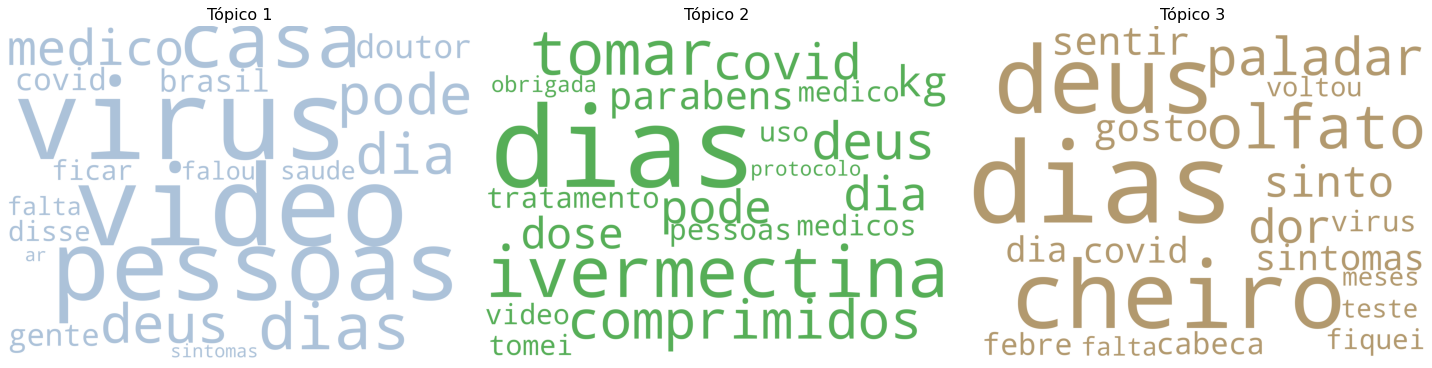

In [18]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = modelo_lda.show_topics(num_words=20, formatted=False)
fig, axes = plt.subplots(1, 3, figsize=(20,20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Tópico ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Resultados

Aqui é mostrado o tópico de cada canal e sua contribuição para seu documento.

In [19]:
from IPython.display import display, HTML
#Criando dataframe para armazenar os resultados
resultado = pd.DataFrame()
resultado['canal'] = ''
resultado['tópico'] = ''
resultado['contribuição'] = ''
resultado['palavras'] = ''

#Obtendo a lista de palavras de cada tópico
palavras = ''
topicos = []
for topico in modelo_lda.show_topics(num_topics=22, num_words=20, formatted=False):
    for tupla in topico[1]:
        palavras += tupla[0]
        palavras += ' '
    topicos.append(palavras)
    palavras = ''
#Preenchendo dataframe com os valores
i = 0
for documento in corpus:
        topics = modelo_lda.get_document_topics(documento, minimum_probability=0.56, minimum_phi_value=None, per_word_topics=False)
        for canal in topics:
            resultado.loc[len(resultado)] = [lista_canais[i]['uploader'].values[0], canal[0]+1, canal[1], topicos[canal[0]]]    
        i += 1
display(HTML(resultado.to_html()))
#print(resultado.to_html())

,canal,tópico,contribuição,palavras
0,Dr. Alain Dutra,2,0.983082,dias ivermectina tomar comprimidos deus covid dia pode dose kg parabens pessoas tratamento medicos tomei medico video uso obrigada protocolo
1,Dr. Alvaro Galvão,2,0.972350,dias ivermectina tomar comprimidos deus covid dia pode dose kg parabens pessoas tratamento medicos tomei medico video uso obrigada protocolo
2,Dr. Felipe Ades MD PhD,3,0.949731,dias cheiro deus olfato paladar dor sinto sentir gosto sintomas covid dia cabeca febre virus fiquei voltou teste meses falta
3,Dr. Fernando Gomes,2,0.916792,dias ivermectina tomar comprimidos deus covid dia pode dose kg parabens pessoas tratamento medicos tomei medico video uso obrigada protocolo
4,Dr. Lair Ribeiro Oficial,1,0.562090,virus video pessoas casa dias pode dia deus medico doutor brasil covid gente disse ficar saude falta falou sintomas ar
5,Drauzio Varella,1,0.988202,virus video pessoas casa dias pode dia deus medico doutor brasil covid gente disse ficar saude falta falou sintomas ar
6,Julio Pereira - Neurocirurgião,3,0.999040,dias cheiro deus olfato paladar dor sinto sentir gosto sintomas covid dia cabeca febre virus fiquei voltou teste meses falta
7,Lucy Kerr,2,0.940965,dias ivermectina tomar comprimidos deus covid dia pode dose kg parabens pessoas tratamento medicos tomei medico video uso obrigada protocolo


## Coherence Values

Aqui são mostrados o valor de coerência do modelo escolhendo diferentes números de tópicos totais.

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [05:30<00:00, 23.59s/it]


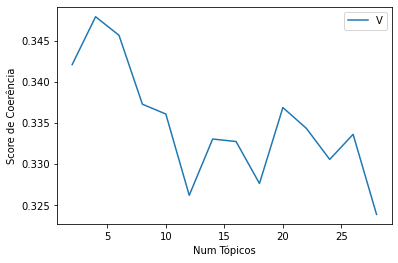

A quantidade de tópicos = 2  tem um valor de coerência de  0.3421
A quantidade de tópicos = 4  tem um valor de coerência de  0.3479
A quantidade de tópicos = 6  tem um valor de coerência de  0.3457
A quantidade de tópicos = 8  tem um valor de coerência de  0.3373
A quantidade de tópicos = 10  tem um valor de coerência de  0.3361
A quantidade de tópicos = 12  tem um valor de coerência de  0.3262
A quantidade de tópicos = 14  tem um valor de coerência de  0.333
A quantidade de tópicos = 16  tem um valor de coerência de  0.3327
A quantidade de tópicos = 18  tem um valor de coerência de  0.3276
A quantidade de tópicos = 20  tem um valor de coerência de  0.3369
A quantidade de tópicos = 22  tem um valor de coerência de  0.3344
A quantidade de tópicos = 24  tem um valor de coerência de  0.3306
A quantidade de tópicos = 26  tem um valor de coerência de  0.3336
A quantidade de tópicos = 28  tem um valor de coerência de  0.3239


In [9]:
# Função para determinar a melhor quantidade de tópicos para a modelagem
from tqdm import tqdm
from gensim.models.ldamulticore import LdaMulticore
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=dictionary, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# Colocando parametros na função
model_list, coherence_values = compute_coherence_values(dictionary=dicionario, corpus=corpus, texts=lista_documentos, start=2, limit=30, step=2)
# Mostrando visualmente a quantidade de tópicos
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))